## ETL (Extract Transform Load) of ATF data files using puppet

**Import all required packages and set a data path**

 - Ensure the data path points to your folder containing a bunch of ATF files. The current code assumes this folder - *labeled atf* - is in the same directory as this Jupyter notebook.

In [6]:
from puppet import ETL, Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

data_path = "./atfs2"
os.path.exists(data_path)

True

**Use puppet ETL to transform the data into the right format for further processing**

In this step we:
 - create a new `ETL` and load in all datasets in the `data_path` (./atf) folder, looking only at files with a `.atf` extension.
 - use `etl.squeeze_all` to remove all columns but *event start time*, *event end time* and *peak amp* from all datasets.
 - use `etl.column_transform` to turn *peak amp* into a positive decimal value on all datasets
 - use `etl.column_transform` to convert *event start time* from milliseconds to seconds on all datasets
 - use `etl.column_transform` to convert *event end time* from milliseconds to seconds on all datasets
 - use `etl.column_rename_all` to shorten start and end time column names on all datasets

Finally, after our transformations, we print out the resulting dataframe

In [7]:
etl = ETL().load_dir(data_path, ".atf")
etl.squeeze_all("Event Start Time (ms)", "Event End Time (ms)", "Peak Amp (pA)")
etl.column_transform_all("Peak Amp (pA)", lambda x: abs(float(x)))
etl.column_transform_all("Event Start Time (ms)", lambda x: float(x) / 1000)
etl.column_transform_all("Event End Time (ms)", lambda x: float(x) / 1000)

etl.column_rename_all("Event Start Time (ms)", "Start")
etl.column_rename_all("Event End Time (ms)", "End")

etl.datasets[0].df

30 datasets loaded from ./atfs2/*.atf


,Peak Amp (pA),Start,End
0,23.91289,3.204860,3.223160
1,19.43435,3.663760,3.682060
2,23.31320,4.324700,4.343000
3,14.20337,7.015620,7.033920
4,38.69088,7.057040,7.075340
...,...,...,...
282,35.41550,292.974000,292.992313
283,21.63378,294.402875,294.421188
284,11.17513,296.176625,296.194938
285,15.65113,297.256469,297.274781


**Create IEI, Cell, and Control columns**

Below, we define three transformation functions. Each of these take in two values:
 - `row`: a row number of a dataset
 - `ds`: the dataset itself

these functions will be mapped over every row in every dataset iteratively. below we use the row id argument (`row`) and the dataset argument (`ds`) to create new columns from existing ones.

In [8]:
# for every row but the first in a dataset,
# the new column on row n should be (row[n].start_time - row[n-1].end_time)
def with_iei(row: int, ds: Dataset):
    if row == 0:
        return 0
    
    end_time = ds.get("End", row - 1)
    start_time = ds.get("Start", row)
    return start_time - end_time

# for every row in a dataset
# if the dataset file name contains the word 'control'
# the new column on row n should be True, if the filename does not contain
# 'control', the new column on row n should be False
def with_control(row: int, ds: Dataset):
    if "control" in ds.filename.lower():
        return True
    return False

# for every row in a dataset
# the new column on row n should be the number after 'cell_' in the filename
def with_cell_number(row: int, ds: Dataset):
    if ds.filename.startswith("cell_"):
        cell_num = ds.filename.split("_")[1]
        return int(cell_num)
    else:
        p = ds.filename.replace("cell", "")
        p = p.split("_")
        return int(p[0])
    
# we pass our extension functions to etl here, applying them to the datasets etl holds.
etl.extend_all("IEI", with_iei)
etl.extend_all("Cell", with_cell_number)
etl.extend_all("Control", with_control)
etl.datasets[0].df

,Peak Amp (pA),Start,End,IEI,Cell,Control
0,23.91289,3.204860,3.223160,0.000000,2,True
1,19.43435,3.663760,3.682060,0.440600,2,True
2,23.31320,4.324700,4.343000,0.642640,2,True
3,14.20337,7.015620,7.033920,2.672620,2,True
4,38.69088,7.057040,7.075340,0.023120,2,True
...,...,...,...,...,...,...
282,35.41550,292.974000,292.992313,0.049594,2,True
283,21.63378,294.402875,294.421188,1.410562,2,True
284,11.17513,296.176625,296.194938,1.755437,2,True
285,15.65113,297.256469,297.274781,1.061531,2,True


**Let's clone our `etl` variable. This will allow us to do cell-by-cell organization as well as accumulated control-iBEP organization**

In [9]:
from copy import deepcopy

etl_split_cells = etl
etl_split_control = deepcopy(etl)

**Ok friend! We will now gather stats for every cell and compare stats from control-cell-n to iBEP-cell-n**

Control cell stats:


,cell,mean_amp,max_amp,min_amp,t25_quantile,t25_events,tot_events,mean_iei,max_iei,min_iei
0,2,23.216833,133.98837,8.81539,26.212805,72,287,1.013894,7.396297,-0.018032
1,12,15.688400,120.24337,0.00000,17.719650,166,664,0.199615,1.626437,-0.024320
2,15,31.153976,82.12085,16.98794,34.667568,48,192,0.900345,4.340125,-0.034141
3,13,18.312882,57.20681,7.72459,21.388192,77,308,0.460281,3.802199,-0.024240
4,14,46.878682,259.73370,19.34844,52.457865,341,1363,0.055930,0.571980,-0.031918
5,10,31.258213,113.42014,17.39667,32.776145,39,155,0.731872,4.376279,-0.034125
6,5,14.907604,27.98304,9.74719,16.263912,34,136,2.082004,10.582968,-0.052219
7,11,31.258213,113.42014,17.39667,32.776145,39,155,0.731872,4.376279,-0.034125
8,9,31.970428,355.73929,13.97947,29.482028,61,242,0.704382,5.300605,-0.034407
9,1,22.752351,64.35026,9.54917,28.131425,127,506,0.570386,5.576200,-0.017137


iBEP cell stats:


,cell,mean_amp,max_amp,min_amp,t25_quantile,t25_events,tot_events,mean_iei,max_iei,min_iei
0,5,15.008627,57.29947,8.25542,18.072398,61,242,1.166163,6.799656,-0.052281
1,1,21.488305,85.10651,9.37508,23.320815,72,287,1.025742,6.731156,-0.017078
2,14,52.871507,221.78952,20.20585,61.053890,157,629,0.158133,1.313343,-0.031938
3,15,41.695784,153.23897,13.03038,61.863595,77,306,0.549630,5.065750,-0.034375
4,12,14.196467,71.70345,6.18727,15.990055,103,411,0.336858,2.504211,-0.024320
5,3,10.618140,33.29081,5.58948,13.075010,47,189,1.516413,6.048469,-0.064093
6,4,52.518346,296.20407,21.39021,50.931183,266,1064,0.261891,2.107204,-0.019460
7,11,18.900118,52.58472,9.12414,22.392760,129,515,0.199314,1.347375,-0.034375
8,6,30.113667,182.42194,9.29622,27.110715,432,1727,0.070577,0.506437,-0.025250
9,9,27.560934,142.13542,12.19680,33.163120,95,378,0.442458,3.021187,-0.034407


Mean Amp Comparison Per Cell - Control (blue) vs iBEP (red)


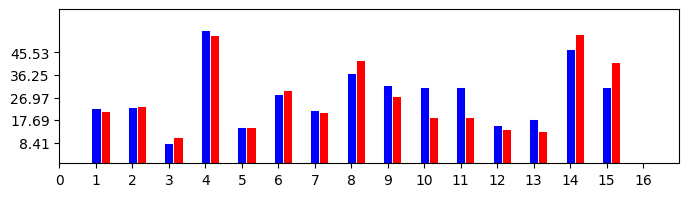

Mean IEI Comparison Per Cell - Control (green) vs iBEP (purple)


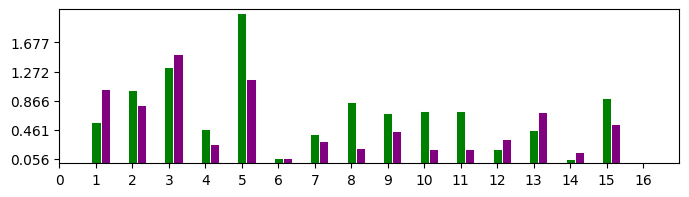

Frequency Of Events Over .75 Quantile Per Cell - Control (black) vs iBEP (pink)


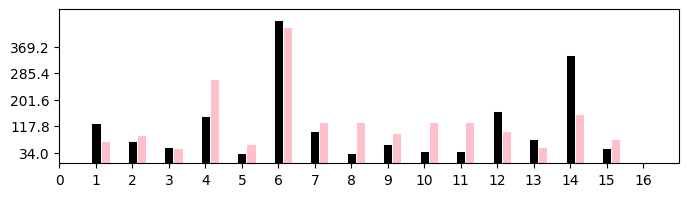

In [91]:
def gather_cell_stats(ds: Dataset):
    mean_amp = ds.df["Peak Amp (pA)"].mean()
    min_amp = ds.df["Peak Amp (pA)"].min()
    max_amp = ds.df["Peak Amp (pA)"].max()
    
    tot_event_ct = ds.df["Peak Amp (pA)"].shape[0]
    t25_quantile = ds.df["Peak Amp (pA)"].quantile(0.75)
    percentile_event_ct = ds.df[ds.df["Peak Amp (pA)"] > t25_quantile].shape[0]
    
    
    mean_iei = ds.df["IEI"].mean()
    min_iei = ds.df["IEI"].min()
    max_iei = ds.df["IEI"].max()
    
    cell_num = int(ds.df.iloc[0]["Cell"])
    control = bool(ds.df.iloc[0]["Control"])
    
    stats = {
        "cell": cell_num,
        "mean_amp": mean_amp, 
        "max_amp": max_amp, 
        "min_amp": min_amp, 
        "t25_quantile": t25_quantile,
        "t25_events": percentile_event_ct,
        "tot_events": tot_event_ct,
        "mean_iei": mean_iei, 
        "max_iei": max_iei, 
        "min_iei": min_iei
    }
    
    return cell_num, control, stats

control_cellst = {}
control_cellst_df = None
ibep_cellst = {}
ibep_cellst_df = None

for d in etl_split_cells.datasets:
    cell_num, control, stats = gather_cell_stats(d)
    if control:
        control_cellst[cell_num] = stats
    else:
        ibep_cellst[cell_num] = stats
        
control_cellst_df = pd.DataFrame(control_cellst.values())
ibep_cellst_df = pd.DataFrame(ibep_cellst.values())

print("Control cell stats:")
display(control_cellst_df)

print("iBEP cell stats:")
display(ibep_cellst_df)


def fun_exciting_graph(control: pd.DataFrame, ibep: pd.DataFrame, feature: str, ibep_color: str, control_color: str):
    cell_ct = max(control.shape[0], control.shape[0])
    
    control = control.sort_values(by="cell")
    ibep = ibep.sort_values(by="cell")
    
    control_x = 1 + np.arange(control.shape[0])
    control_y = control[feature]
    
    ibep_x = 1.25 + np.arange(ibep.shape[0])
    ibep_y = ibep[feature]
    
    max_y = max(control_y.max(), ibep_y.max())
    min_y = min(control_y.min(), ibep_y.min())
    
    x = 0.5 + np.arange(8)
    y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

    # plot
    fig, ax = plt.subplots(figsize=(8, 2))
    
    ax.bar(control_x, control_y, width=1/4, edgecolor="white", linewidth=0.7, color=control_color)
    ax.bar(ibep_x, ibep_y, width=1/4, edgecolor="white", linewidth=0.7, color=ibep_color)

    ax.set(xlim=(0, cell_ct + 2), xticks=np.arange(0, cell_ct + 2),
        ylim=(0, max_y + min_y), yticks=np.arange(min_y, max_y, step=(max_y - min_y) / 5))

    plt.show()
    
    
print("Mean Amp Comparison Per Cell - Control (blue) vs iBEP (red)")
fun_exciting_graph(control_cellst_df, ibep_cellst_df, feature="mean_amp", ibep_color="red", control_color="blue")

print("Mean IEI Comparison Per Cell - Control (green) vs iBEP (purple)")
fun_exciting_graph(control_cellst_df, ibep_cellst_df, feature="mean_iei", ibep_color="purple", control_color="green")

print("Frequency Of Events Over .75 Quantile Per Cell - Control (black) vs iBEP (pink)")
fun_exciting_graph(control_cellst_df, ibep_cellst_df, feature="t25_events", ibep_color="pink", control_color="black")

**Now lets create an algorithm for detecting bursts and graph the burst count for ibep and control cells**

Bursts during control 893
Bursts during iBEP 1143
Burst Comparison Per Cell - Control (purple) vs iBEP (green)


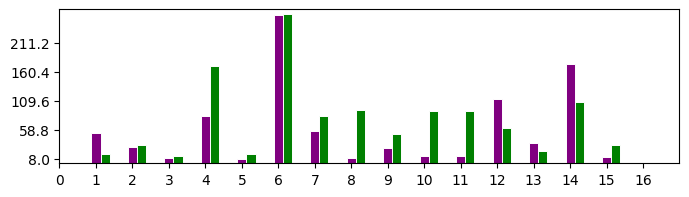

In [80]:
def starburst(ds: Dataset, burst_window=0.5, min_events=2):
    burst_dict = {}
    events_ts = sorted([ s for s in ds.data["Start"] ])
    
    ix = 0
    
    while ix < len(events_ts):
        target = events_ts[ix]
        events_in_window = 0
        window_usage = 0
                
        did_crawl = False        
                
        for crawl in range(ix + 1, len(events_ts)):
            crawl_target = events_ts[crawl]
            window_usage = crawl_target - target
            
            if window_usage < burst_window:
                events_in_window += 1
            else:
                if events_in_window >= min_events:
                    burst_dict[ix] = events_in_window
                    ix = crawl
                    break
                else:
                    ix += 1
                    
                events_in_window = 0
                window_usage = 0
                did_crawl = True
                break
            
        if not did_crawl:
            ix += 1
                    
                    
    return burst_dict

# apply this burst counter to control and iBEP

bursts_control = {}
bursts_ibep = {}

bursts_control_tot = 0
bursts_ibep_tot = 0

for ds in etl_split_cells.datasets:
    cell_num = float(ds.df.iloc[0]["Cell"])
    control = "control" in ds.filename.lower()
    
    b = len(starburst(ds))
    
    if control:
        bursts_control[cell_num] = (cell_num, b)
        bursts_control_tot += b
    else:
        bursts_ibep[cell_num] = (cell_num, b)
        bursts_ibep_tot += b
        
print("Bursts during control", bursts_control_tot)
print("Bursts during iBEP", bursts_ibep_tot)

def fun_freaky_graph(cell_control, cell_ibep, ibep_color: str, control_color: str):
    cell_ct = max(len(cell_control), len(cell_ibep))
    
    control_x = 1 + np.arange(len(cell_control))
    control_y = cell_control
    
    ibep_x = 1.25 + np.arange(len(cell_ibep))
    ibep_y = cell_ibep
    
    max_y = max(max(control_y), max(ibep_y))
    min_y = min(min(control_y), min(ibep_y))

    # plot
    fig, ax = plt.subplots(figsize=(8, 2))
    
    ax.bar(control_x, control_y, width=1/4, edgecolor="white", linewidth=0.7, color=control_color)
    ax.bar(ibep_x, ibep_y, width=1/4, edgecolor="white", linewidth=0.7, color=ibep_color)

    ax.set(xlim=(0, cell_ct + 2), xticks=np.arange(0, cell_ct + 2),
        ylim=(0, max_y + min_y), yticks=np.arange(min_y, max_y, step=(max_y - min_y) / 5))

    plt.show()
    
cells_ibep = [x[1] for x in sorted(list(bursts_ibep.values()), key=lambda x: x[0])]
cells_control = [x[1] for x in sorted(list(bursts_control.values()), key=lambda x: x[0])]

print("Burst Comparison Per Cell - Control (purple) vs iBEP (green)")
fun_freaky_graph(cells_control, cells_ibep, "green", "purple")

# **END OF REAL PROGRESS**

everything below is just example shit

**Crush down our howevermany datasets into two large datasets: control and test**

We use `etl.crush` to define two reducer functions that apply to datasets. If a reducer called on a dataset returns `True`, the dataset will be crushed into that group.

The below example shows a crush into just two resulting datasets, but by passing more reducers to the `etl.crush` function you could crush into any number of parent datasets.

In [ ]:
etl.crush({
    "control": lambda ds: "control" in ds.filename,
    "test": lambda ds: "control" not in ds.filename
})

print(f"crushed into {len(etl.datasets)} datasets")

print("Crushed 'control' group:")
print(etl.datasets[0].df)

print("Crushed 'test' group:")
print(etl.datasets[1].df)

**Lets use dataframes to get some stats!**

The `etl.datasets[0].df` object you've been seeing in the code is a pandas dataframe. `puppet.py` generates one for every dataset. Dataframes are like an excel spreadsheet - or interactive CSV - in python. essentially just rows and columns of organized data. Dataframes are better than Excel and CSVs though, primarily because I like them more but also because they're extremely easy to perform statistical operations on.

Below we'll find some statistical values.

In [ ]:
control_group_dataframe = etl.datasets[0].df

mean_peak_amps = control_group_dataframe["Peak Amp (pA)"].mean()
stddev_peak_amps = control_group_dataframe["Peak Amp (pA)"].std()
median_peak_amps = control_group_dataframe["Peak Amp (pA)"].median()
mean_iei = control_group_dataframe["IEI"].mean()

print("Mean peak amps: ", mean_peak_amps)
print("Standard Deviation peak amps: ", stddev_peak_amps)
print("Median peak amps: ", median_peak_amps)
print("Mean IEI: ", mean_iei)

**We are gonna get graphical baby!**

Let's graph some stuff using matplotlib, great way to show visualizations in python.

Also before Tuesday July 2 I had no idea how to use matplotlib, so this is a testament to how easy it is to copy paste shit from the internet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

control_iei = etl.datasets[0].df["IEI"]
test_iei = etl.datasets[1].df["IEI"]
max_iei = max(control_iei.max(), test_iei.max())
min_iei = min(control_iei.min(), test_iei.min())

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(3, 3))

VP = ax.boxplot(
    (control_iei, test_iei), 
    positions=[3, 6], 
    widths=1.5,
    showmeans=False, 
    showfliers=False,
    patch_artist=True,
    medianprops={"color": "white", "linewidth": 0.5},
    boxprops={"facecolor": "C0", "edgecolor": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5})

ax.set(xlim=(0, 9), ylim=(min_iei - 1, max_iei + 1), xticks=np.arange(1,9), yticks=np.arange(min_iei, max_iei))

plt.gca().set_xticklabels([ "iei control" if x == 3 else "iei test" if x == 6 else "" for x in np.arange(1, 9)])
plt.show()

**Now lets draw a line graph, not sure what we want tho will figure it out later nerd**

In [ ]:

fig, ax = plt.subplots(figsize=(3, 3))

max_x = max(len(control_iei), len(test_iei))

ax.plot(np.arange(0, len(control_iei)), control_iei.add(1), color="red")
ax.plot(np.arange(0, len(test_iei)), test_iei, linewidth=1.0)

ax.set(xlim=(0, max_x), xticks=[],
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()